# Inleiding

Bij de November 2023 is overgegaan op het toepassen van drag afkapping bij lokale golfgroei door wind. Als gevolg hiervan zijn de oude resultaten niet langer correct. In de niewste release zijn geupdate resultaten meegeleverd. 

In dit notebook wordt geanalyseerd of de oude (voor Urk zijn de oude bewaard binnen de HBH distributie) en nieuwe resultaten consistent zijn door voor een enkel geval de numerieke resultaten te controleren. We vergelijken daartoe stapsgewijs de strijklengte en waterdiepte voor een gekozen conditie en berekenen de golfgroei volgens de oude en nieuwe methode. Deze vergelijken we met de oude en nieuwe resultaten om te kijken of alles consistent is.

# Imports

In [1]:
import sys
import os
import shutil
# import copy
# import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

owd = os.getcwd()
testdir = os.path.dirname(owd)
sys.path.append(testdir)
trunkdir = os.path.dirname(testdir)
sys.path.append(trunkdir)

import common
from hbhavens.core.models import MainModel
from hbhavens.core.geometry import extend_point_to_linestring

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Schematisatie

In [2]:
case = 'urk'
datadir = os.path.join(trunkdir, 'tests', 'data', case)
paths = {
    'harborarea': os.path.join(datadir, 'shapes', 'haventerrein.shp'),
    'breakwater': os.path.join(datadir, 'shapes', 'havendammen.shp'),
    'result_locations': os.path.join(datadir, 'shapes', 'uitvoerlocaties.shp'),
    'hrd': os.path.join(datadir, 'databases', 'WBI2017_IJsselmeer_7-2_v02_steunpunt.sqlite'),
    'config': os.path.join(datadir, 'databases', 'WBI2017_IJsselmeer_7-2_v02_steunpunt.config.sqlite'),
    'hlcd': os.path.join(datadir, '..', 'hlcd.sqlite'),
}
trajecten = ['7-2']
bedlevel = -5.0
supportlocation = 'YM_3_7-2_ha02_00001'

# Create and run for various combinations of processes

In [3]:
tempdir = os.path.join(os.path.dirname(trunkdir),'temp')
if os.path.isdir(tempdir):
    shutil.rmtree(tempdir)
os.mkdir(tempdir)

In [4]:
model = MainModel()
model.project.settings['project']['name'] = case
model.project.settings['project']['user']['email'] = 'benit@hkv.nl'
model.project.settings['project']['user']['name'] = 'Matthijs Bénit'
model.project.save_as(os.path.join(tempdir, case + '.json'))

common.add_schematisation(model, paths=paths, supportlocationname=supportlocation, trajecten=trajecten, bedlevel=bedlevel)

# Calculate wave processes
model.simple_calculation.run_all(['Lokale golfgroei'])
model.simple_calculation.combinedresults.run(['Lokale golfgroei'])
model.simple_calculation.mainmodel.project.settings['simple']['finished'] = True
model.simple_calculation.save_results()

# Save results
model.project.save()
model.save_tables()

In [5]:
model.simple_calculation.wavegrowth.output.to_csv('wavegrowth_results_urk_BU', sep=";", decimal=".", compression='gzip')

# Manually reproduce results

In [6]:
table_path = os.path.join(trunkdir,'tests', "data", "urk",'simple', 'wavegrowth_results_urk_BU.gz')
old = pd.read_csv(table_path, sep=";", decimal=".")
new = model.simple_calculation.wavegrowth.output.reset_index()

In [7]:
locations = old['Location'].unique()
location = locations[0]
iloc = model.schematisation.result_locations.loc[model.schematisation.result_locations['Naam'] ==  location].index[0]
location, iloc

('7-2_00001', 0)

In [8]:
hydraulicloadid = model.hydraulic_loads.loc[(model.hydraulic_loads['Wind direction'] == 270.) & (model.hydraulic_loads['Wind speed'] == 42.) & (model.hydraulic_loads['Water level IJssel lake'] == 1.8)].index[0]
hydraulicloadid
model.hydraulic_loads.loc[hydraulicloadid]

28308

ClosingSituationId                           1
Wind direction                           270.0
Water level IJssel lake                    1.8
Wind speed                                42.0
h                                        4.291
Hs                                       3.139
Tp                                        6.68
Tm-1,0                                  5.5808
Wave direction                          261.58
Description                D=270.0 M=1.80 U=42
Name: 28308, dtype: object

In [9]:
iold = old.loc[(old['Location'] == location) & (old['HydraulicLoadId'] == hydraulicloadid)].index
old.iloc[iold]

,Location,HydraulicLoadId,Wind direction,Wind speed,Water level,U10,Feq,maxdir,Terrain level,Water depth,"Hs,lg",Elg
544,7-2_00001,28308,270.0,42.0,4.291,43.3,753.07437,298.0,-5.0,9.291,1.140727,0.081329


In [10]:
inew = new.loc[(new['Location'] == location) & (new['HydraulicLoadId'] == hydraulicloadid)].index
new.iloc[inew]

,Location,HydraulicLoadId,Wind direction,Wind speed,Water level,U10,Feq,maxdir,Terrain level,Water depth,"Hs,lg",Elg
544,7-2_00001,28308,270.0,42.0,4.291,40.02,753.07437,298.0,-5.0,9.291,1.046352,0.068428


In [11]:
# assert geometry and hydraulic loads are the same
assert(old.iloc[iold]['Wind speed'].values[0] - new.iloc[inew]['Wind speed'].values[0] < .01)
assert(old.iloc[iold]['Feq'].values[0] - new.iloc[inew]['Feq'].values[0] < .01)
assert(old.iloc[iold]['Water depth'].values[0] - new.iloc[inew]['Water depth'].values[0] < .01)


<Axes: >

Text(169548.22228293325, 518940.1816895012, '7-2_00001')

(168800.0, 169800.0)

(518600.0, 519600.0)

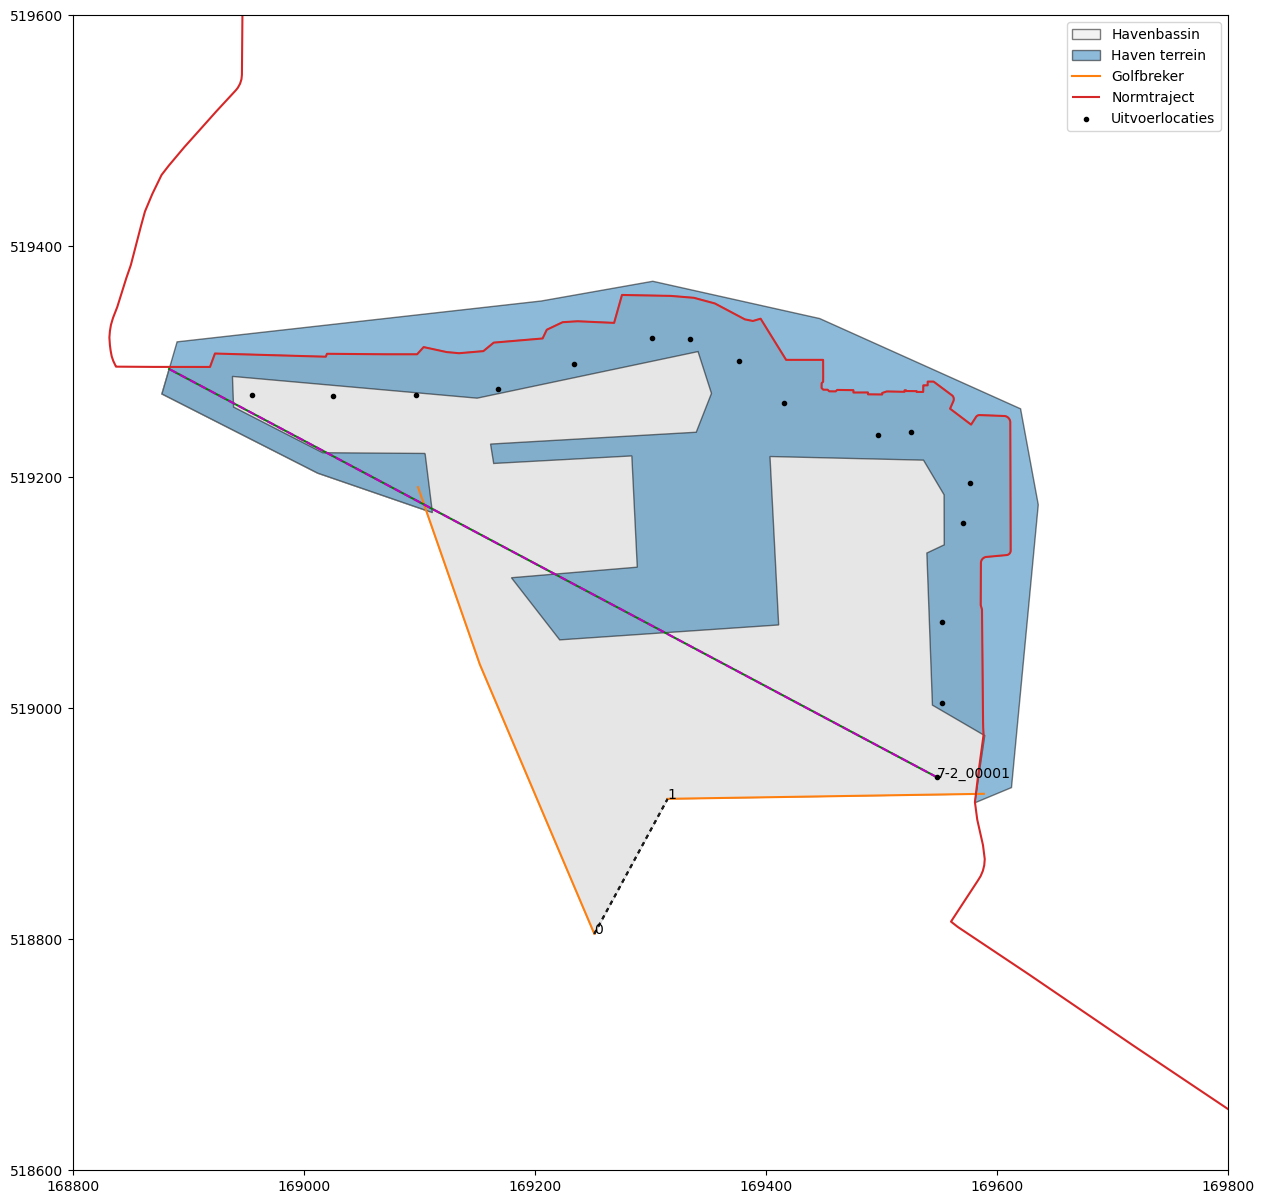

In [12]:
# plot schematisation and fetch of selected (old) result
fig, ax = model.schematisation.plot_schematisation(buffer=10,locations=False)
model.schematisation.result_locations.plot(ax=ax, color='k', marker='.', zorder=10, label='Uitvoerlocaties')
loc = model.schematisation.result_locations.iloc[iloc]
ax.text(loc['geometry'].coords[0][0], loc['geometry'].coords[0][1], loc['Naam'])

oldline = extend_point_to_linestring(model.schematisation.result_locations.iloc[iloc]['geometry'], old.iloc[iold]['maxdir'].values[0], (0, -old.iloc[iold]['Feq'].values[0]))
newline = extend_point_to_linestring(model.schematisation.result_locations.iloc[iloc]['geometry'], new.iloc[iold]['maxdir'].values[0], (0, -new.iloc[iold]['Feq'].values[0]))
ax.plot(oldline[:,0],oldline[:,1],'g')
ax.plot(newline[:,0],newline[:,1],'m--')

ax.legend(loc='upper right')
ax.set_xlim(xmin=168800,xmax=169800, auto=True)
ax.set_ylim(ymin=518600,ymax=519600, auto=True)

In [13]:
# get old and new relation between Upot and U10
Upot2U10file = os.path.join(trunkdir, 'hbhavens', 'data', 'Up2U10', 'Up2U10.dat')
Upot2U10old = pd.read_csv(Upot2U10file, comment='%', header=None, delim_whitespace=True, names=['Upot', 'U10'], encoding='latin-1', usecols=[0,1])
Upot2U10new = pd.read_csv(Upot2U10file, comment='%', header=None, delim_whitespace=True, names=['Upot', 'U10'], encoding='latin-1', usecols=[0,3])

In [14]:
# check if calculated U10 are consistent with old and new relation in Upot2U10
U10old = np.interp(model.hydraulic_loads.loc[hydraulicloadid]['Wind speed'], Upot2U10old['Upot'].values, Upot2U10old['U10'].values, left=np.nan, right=np.nan)
U10new = np.interp(model.hydraulic_loads.loc[hydraulicloadid]['Wind speed'], Upot2U10new['Upot'].values, Upot2U10new['U10'].values, left=np.nan, right=np.nan)

assert(U10old == old.iloc[iold]['U10'].values[0])
assert(U10new == new.iloc[inew]['U10'].values[0])

In [15]:
# reproduce old results
H = model.simple_calculation.wavegrowth.bretschneider(
            old.iloc[iold]['Water depth'].values,
            old.iloc[iold]['Feq'].values,
            U10old
        )
H[0][0],old.iloc[iold]['Hs,lg'].values[0]
assert(H[0][0] - old.iloc[iold]['Hs,lg'].values[0] < .01)

(1.140727458189822, 1.140727458189822)

In [16]:
# reproduce new results
H = model.simple_calculation.wavegrowth.bretschneider(
            new.iloc[inew]['Water depth'].values,
            new.iloc[inew]['Feq'].values,
            U10new
        )
H[0][0],new.iloc[inew]['Hs,lg'].values[0]
assert(H[0][0] - new.iloc[inew]['Hs,lg'].values[0] < .01)

(1.046352088348546, 1.046352088348546)

In [17]:
# reproduce new results using old input but new Upot2U10
H = model.simple_calculation.wavegrowth.bretschneider(
            old.iloc[iold]['Water depth'].values,
            old.iloc[iold]['Feq'].values,
            np.interp(model.hydraulic_loads.loc[hydraulicloadid]['Wind speed'], Upot2U10new['Upot'].values, Upot2U10new['U10'].values, left=np.nan, right=np.nan)
        )
H[0][0],new.iloc[inew]['Hs,lg'].values[0]
assert(H[0][0] - new.iloc[inew]['Hs,lg'].values[0] < .01)

(1.046352088348546, 1.046352088348546)